# AIM460 — Advanced Clustering & Density Methods  
 by *Bryan Carrillos*



## 1. Dataset Selection & Exploration

This assignment uses four classic benchmark datasets, all accessed via `sklearn.datasets`. Their original sources are from the **UCI Machine Learning Repository** or research archives.

- **Iris**  
  - Source: [R.A. Fisher (1936), UCI ML Repository](https://archive.ics.uci.edu/dataset/53/iris)  
  - Structure: 150 samples × 4 features; 3 known classes (for evaluation only)  
  - Assumption: Compact, roughly Gaussian clusters  
  - Preprocessing: Standardized using `StandardScaler`

- **Wine**  
  - Source: [Forina et al., UCI ML Repository](https://archive.ics.uci.edu/dataset/109/wine)  
  - Structure: 178 samples × 13 features; 3 known classes (for evaluation only)  
  - Assumption: Skewed feature distributions; elongated clusters  
  - Preprocessing: Standardized using `StandardScaler`

- **Breast Cancer (Wisconsin Diagnostic)**  
  - Source: [Wolberg et al. (1991), UCI ML Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)  
  - Structure: 569 samples × 30 features; 2 known classes (for evaluation only)  
  - Assumption: Non-spherical clusters; varying density  
  - Preprocessing: Standardized using `StandardScaler`

- **Digits (Optical Recognition of Handwritten Digits)**  
  - Source: [UCI ML Repository](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)  
  - Structure: 1,797 samples × 64 features (8×8 pixel images); 10 known classes (for evaluation only)  
  - Assumption: High-dimensional, non-convex structures  
  - Preprocessing: Standardized using `StandardScaler`

### Visualization
Each dataset is projected into **2D using PCA** to visualize possible cluster structure. Scatterplots are colored by the true labels for exploration only (labels are not used in clustering).



,Dataset,Source,Samples,Features,Classes (eval only),Scaling
0,Breast Cancer,Wolberg et al. (1991); UCI → sklearn.load_brea...,569,30,2,StandardScaler
1,Digits,UCI 8×8 digits → sklearn.load_digits,1797,64,10,StandardScaler
2,Iris,R.A. Fisher (1936); UCI → sklearn.load_iris,150,4,3,StandardScaler
3,Wine,Forina et al.; UCI → sklearn.load_wine,178,13,3,StandardScaler


,Dataset,Class counts
0,Iris,"{0: 50, 1: 50, 2: 50}"
1,Wine,"{0: 59, 1: 71, 2: 48}"
2,Breast Cancer,"{0: 212, 1: 357}"
3,Digits,"{0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 18..."


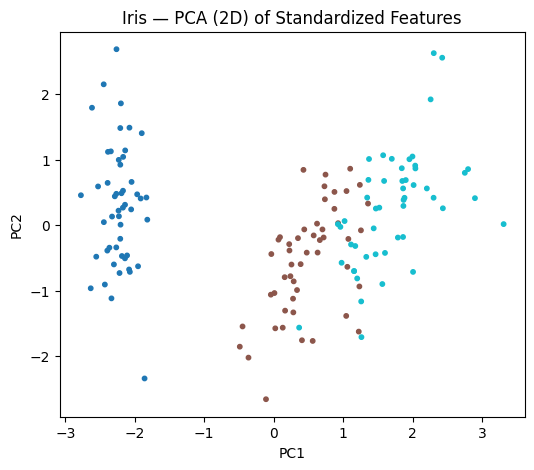

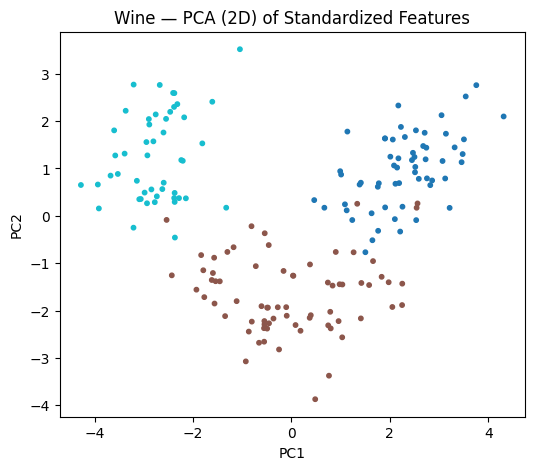

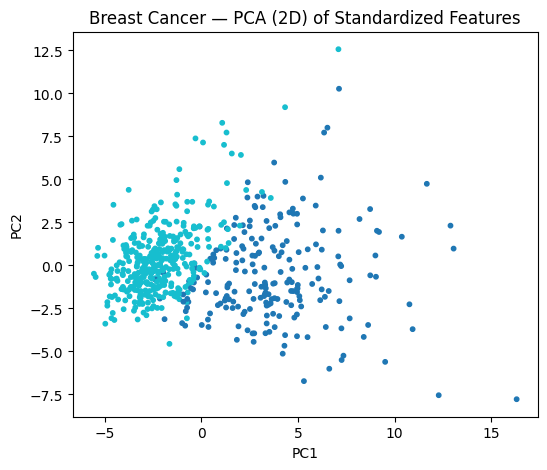

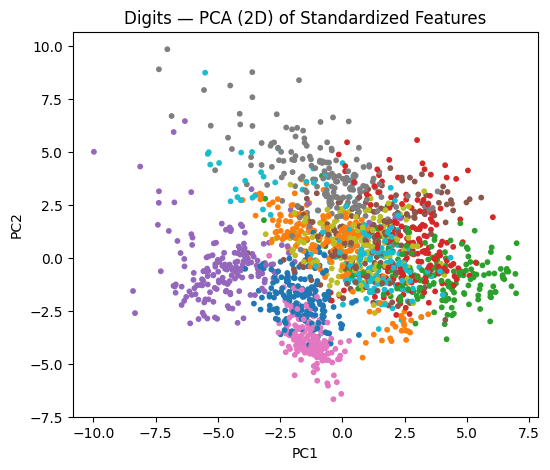

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (6, 5)


iris = datasets.load_iris()
wine = datasets.load_wine()
bc = datasets.load_breast_cancer()
digits = datasets.load_digits()

datasets_dict = {
    "Iris": (iris.data, iris.target, "R.A. Fisher (1936); UCI → sklearn.load_iris"),
    "Wine": (wine.data, wine.target, "Forina et al.; UCI → sklearn.load_wine"),
    "Breast Cancer": (bc.data, bc.target, "Wolberg et al. (1991); UCI → sklearn.load_breast_cancer"),
    "Digits": (digits.data, digits.target, "UCI 8×8 digits → sklearn.load_digits"),
}

# Summary table (computed from arrays to avoid hard-coding)
summary_rows = []
for name, (X, y, src) in datasets_dict.items():
    summary_rows.append({
        "Dataset": name,
        "Source": src,
        "Samples": X.shape[0],
        "Features": X.shape[1],
        "Classes (eval only)": len(np.unique(y)),
        "Scaling": "StandardScaler"
    })

df_summary = pd.DataFrame(summary_rows).sort_values("Dataset").reset_index(drop=True)
display(df_summary)


dist_rows = []
for name, (X, y, _) in datasets_dict.items():
    vals, counts = np.unique(y, return_counts=True)
    dist_rows.append({"Dataset": name, "Class counts": dict(zip(vals.tolist(), counts.tolist()))})
display(pd.DataFrame(dist_rows))

# PCA(2) visualization (colored by true labels for exploration only)
for name, (X, y, _) in datasets_dict.items():
    Xs = StandardScaler().fit_transform(X)
    Z = PCA(n_components=2, random_state=0).fit_transform(Xs)

    plt.figure()
    scatter = plt.scatter(Z[:, 0], Z[:, 1], s=10, c=y, cmap="tab10")
    plt.title(f"{name} — PCA (2D) of Standardized Features")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()


2.1 K-Means Variants

To establish baseline clustering performance, I applied three variants of K-Means:

- **K-Means (random init)**: Uses random centroids; sensitive to initialization.
- **K-Means++**: Smarter centroid initialization to improve stability and convergence.
- **Bisecting K-Means**: A hierarchical variant where the cluster with the largest SSE is repeatedly split into two sub-clusters until the target number of clusters `k` is reached.

For each dataset, the following are reported:
- Centroids
- Labels
- Inertia (sum of squared distances to cluster centers)
- Iterations
- Runtime (seconds)

Visualizations are based on PCA(2), with points colored by the cluster labels for each method.



=== Iris ===


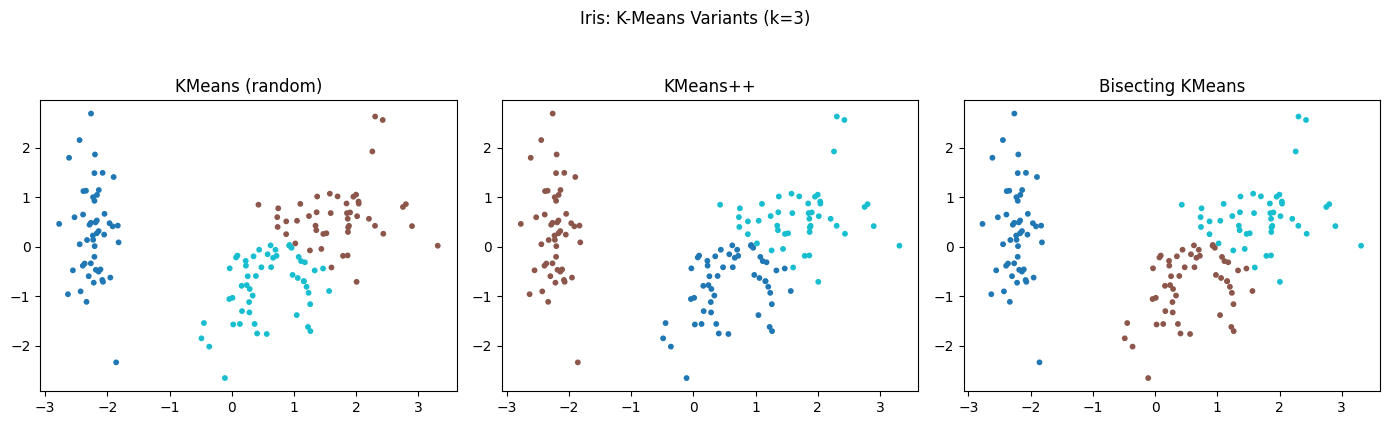


=== Wine ===


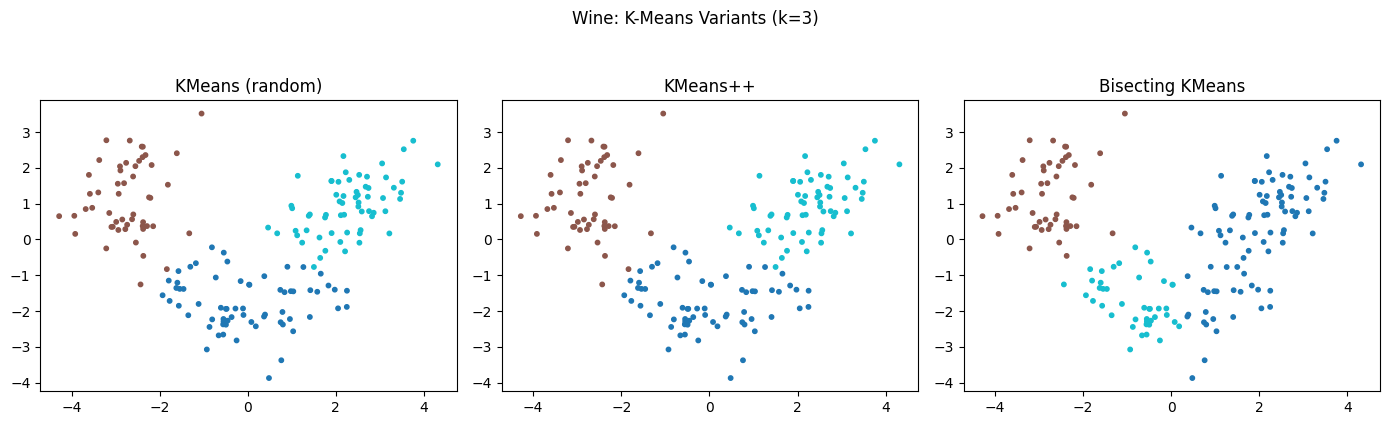


=== Breast Cancer ===


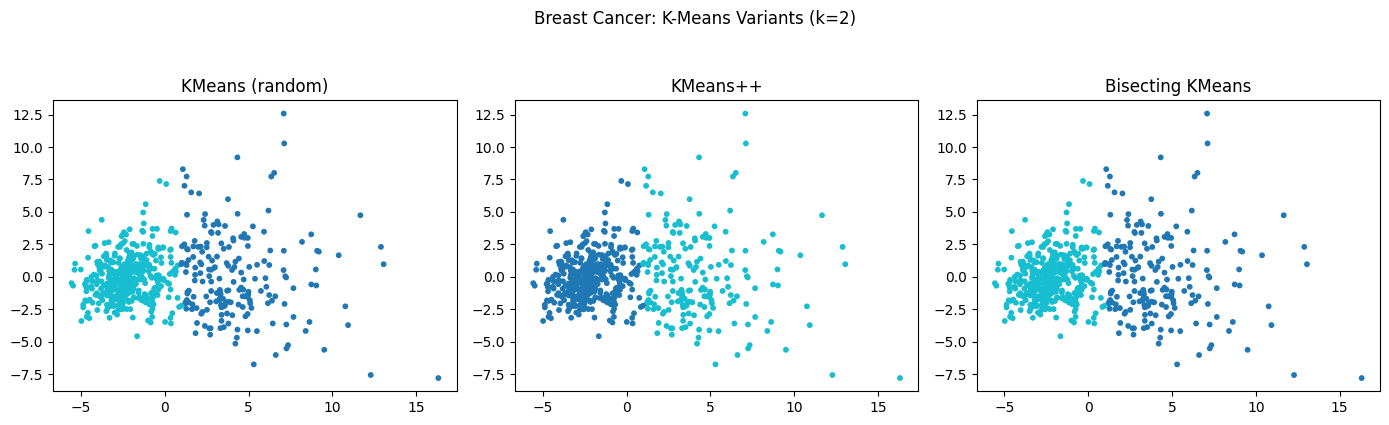


=== Digits ===


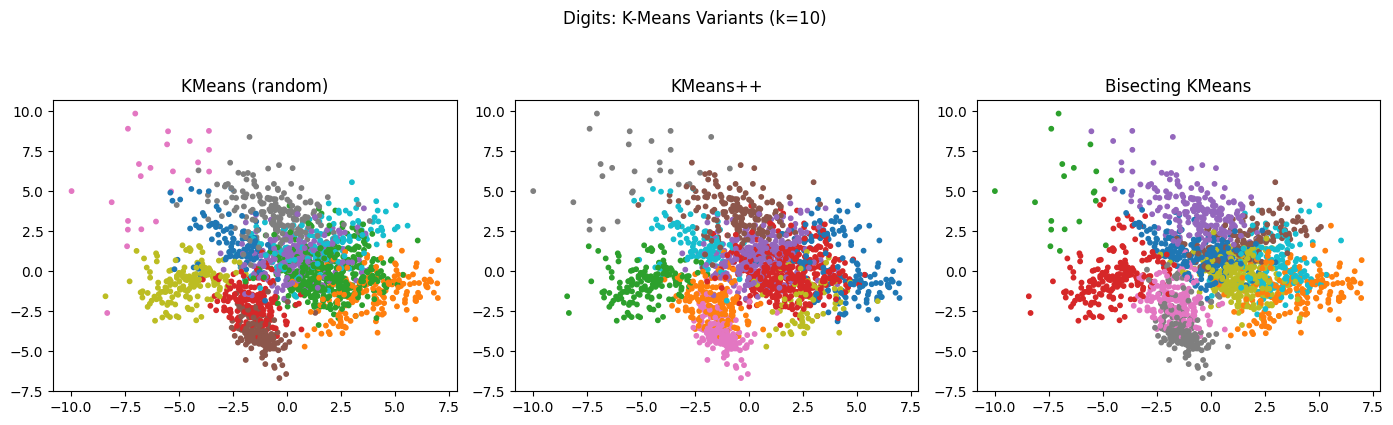

,Dataset,Algorithm,Inertia,Iterations,Runtime
0,Iris,KMeans (random),139.820496,4,0.007756
1,Iris,KMeans++,139.820496,3,0.012280
2,Iris,Bisecting KMeans,139.820496,2,0.017564
3,Wine,KMeans (random),1277.928489,7,0.013319
4,Wine,KMeans++,1277.928489,4,0.015495
5,Wine,Bisecting KMeans,1375.112890,2,0.020676
6,Breast Cancer,KMeans (random),11595.526607,7,0.016629
7,Breast Cancer,KMeans++,11595.526607,6,0.021244
8,Breast Cancer,Bisecting KMeans,11595.526607,1,0.018580
9,Digits,KMeans (random),69735.378021,25,0.166295


In [29]:
import time
from dataclasses import dataclass
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def standardize_and_pca_2d(X):
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    Xs = StandardScaler().fit_transform(X)
    Z = PCA(n_components=2, random_state=0).fit_transform(Xs)
    return Xs, Z


@dataclass
class KMResult:
    centroids: np.ndarray
    labels: np.ndarray
    inertia: float
    iterations: int
    runtime_sec: float

# Standard K-Means (random / K-Means++)
def run_kmeans(X, k, init_method="random", n_init=10, max_iter=300, random_state=0):
    t0 = time.time()
    km = KMeans(n_clusters=k, init=init_method, n_init=n_init,
                max_iter=max_iter, random_state=random_state)
    labels = km.fit_predict(X)
    runtime = time.time() - t0
    return KMResult(
        centroids=km.cluster_centers_,
        labels=labels,
        inertia=km.inertia_,
        iterations=km.n_iter_,
        runtime_sec=runtime
    )


def sse_of_labels(X, labels, centroids):
    sse = 0.0
    for j in range(centroids.shape[0]):
        idx = np.where(labels == j)[0]
        if idx.size == 0: continue
        diffs = X[idx] - centroids[j]
        sse += np.sum(diffs**2)
    return sse

# Bisecting K-Means
def run_bisecting_kmeans(X, k, base_init="k-means++", max_iter=100, random_state=0):
    rng = np.random.RandomState(random_state)
    clusters = {0: np.arange(X.shape[0])}
    centroids_dict = {0: X.mean(axis=0)}
    t0 = time.time()

    while len(clusters) < k:

        sse_by_id = {cid: np.sum((X[idx] - centroids_dict[cid])**2)
                     for cid, idx in clusters.items()}
        split_id = max(sse_by_id, key=sse_by_id.get)
        idx_to_split = clusters[split_id]

        km2 = KMeans(n_clusters=2, init=base_init, n_init=10,
                     max_iter=max_iter, random_state=int(rng.randint(1e9)))
        sub = km2.fit_predict(X[idx_to_split])

        a = max(clusters.keys()) + 1
        b = a + 1
        clusters[a] = idx_to_split[sub == 0]
        clusters[b] = idx_to_split[sub == 1]
        del clusters[split_id]

        centroids_dict[a] = X[clusters[a]].mean(axis=0)
        centroids_dict[b] = X[clusters[b]].mean(axis=0)

    final_ids = sorted(clusters.keys())
    id_map = {cid: i for i, cid in enumerate(final_ids)}
    labels = np.empty(X.shape[0], dtype=int)
    for cid, idx in clusters.items():
        labels[idx] = id_map[cid]
    centroids = np.vstack([centroids_dict[cid] for cid in final_ids])
    inertia = sse_of_labels(X, labels, centroids)
    runtime = time.time() - t0
    iterations = len(final_ids) - 1
    return KMResult(centroids, labels, inertia, iterations, runtime)

rep_k = {"Iris": 3, "Wine": 3, "Breast Cancer": 2, "Digits": 10}
results = []

for name, (X, y, _) in datasets_dict.items():
    print(f"\n=== {name} ===")
    Xs, Z = standardize_and_pca_2d(X)
    k = rep_k[name]

    km_rand = run_kmeans(Xs, k, init_method="random")
    km_pp   = run_kmeans(Xs, k, init_method="k-means++")
    km_bis  = run_bisecting_kmeans(Xs, k)

    results.extend([
        {"Dataset": name, "Algorithm": "KMeans (random)", "Inertia": km_rand.inertia,
         "Iterations": km_rand.iterations, "Runtime": km_rand.runtime_sec},
        {"Dataset": name, "Algorithm": "KMeans++", "Inertia": km_pp.inertia,
         "Iterations": km_pp.iterations, "Runtime": km_pp.runtime_sec},
        {"Dataset": name, "Algorithm": "Bisecting KMeans", "Inertia": km_bis.inertia,
         "Iterations": km_bis.iterations, "Runtime": km_bis.runtime_sec},
    ])

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    axes[0].scatter(Z[:,0], Z[:,1], c=km_rand.labels, s=10, cmap="tab10")
    axes[0].set_title("KMeans (random)")
    axes[1].scatter(Z[:,0], Z[:,1], c=km_pp.labels, s=10, cmap="tab10")
    axes[1].set_title("KMeans++")
    axes[2].scatter(Z[:,0], Z[:,1], c=km_bis.labels, s=10, cmap="tab10")
    axes[2].set_title("Bisecting KMeans")
    fig.suptitle(f"{name}: K-Means Variants (k={k})", y=1.05)
    plt.tight_layout()
    plt.show()

pd.DataFrame(results)

## 2.2 Density & Hierarchical Methods

**Algorithms**
- **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise)  
  - Strengths: arbitrary shapes, noise handling.  
  - Sensitive to `eps` (neighborhood radius) and `min_samples`.  
  - We record: `labels`, `runtime (s)`, and **core sample count**.

- **Agglomerative Clustering** (hierarchical, bottom-up)  
  - **Ward linkage**: merges that minimize within-cluster variance (works best for compact/spherical clusters).  
  - **Complete linkage**: distance between clusters = max pairwise distance (resists chaining, can over-separate).  
  - We record: `labels` and `runtime (s)`.

**Settings**
- Features are standardized (from Step 1).  
- For each dataset we use a representative `k` (Iris=3, Wine=3, Breast Cancer=2, Digits=10).  
- For DBSCAN we start with reasonable, per-dataset defaults and can retune in Step 5 hyperparameter sweeps.  
- Visualization: PCA(2) scatterplots colored by **cluster labels** for **DBSCAN**, **Agglomerative (Ward)**, and **Agglomerative (Complete)**.


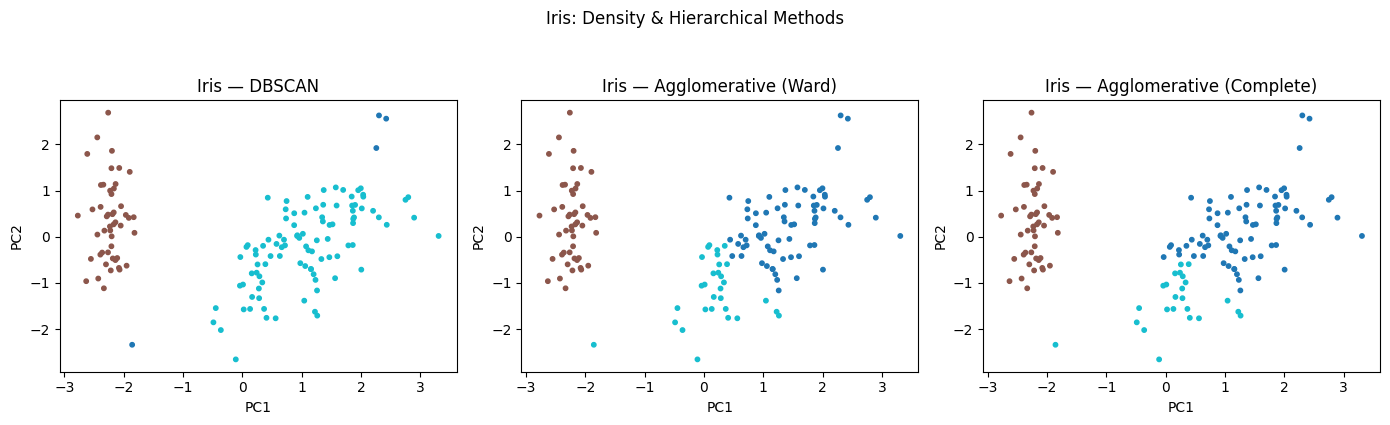

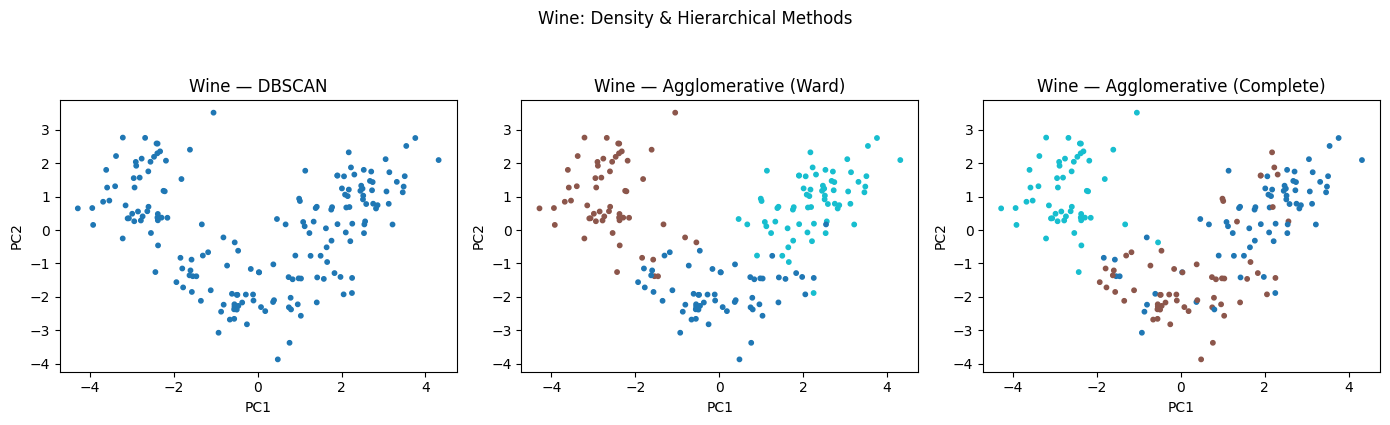

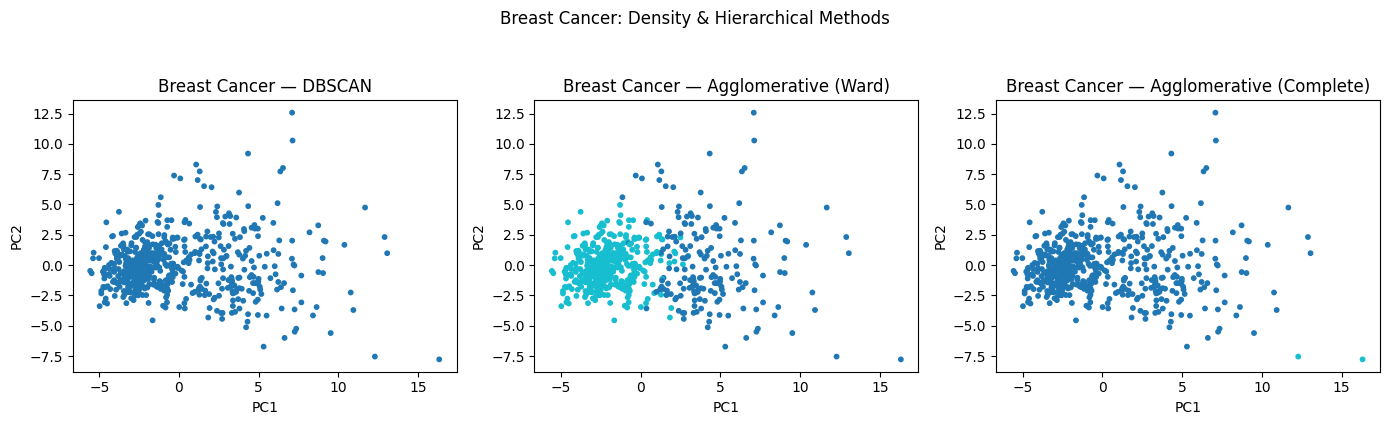

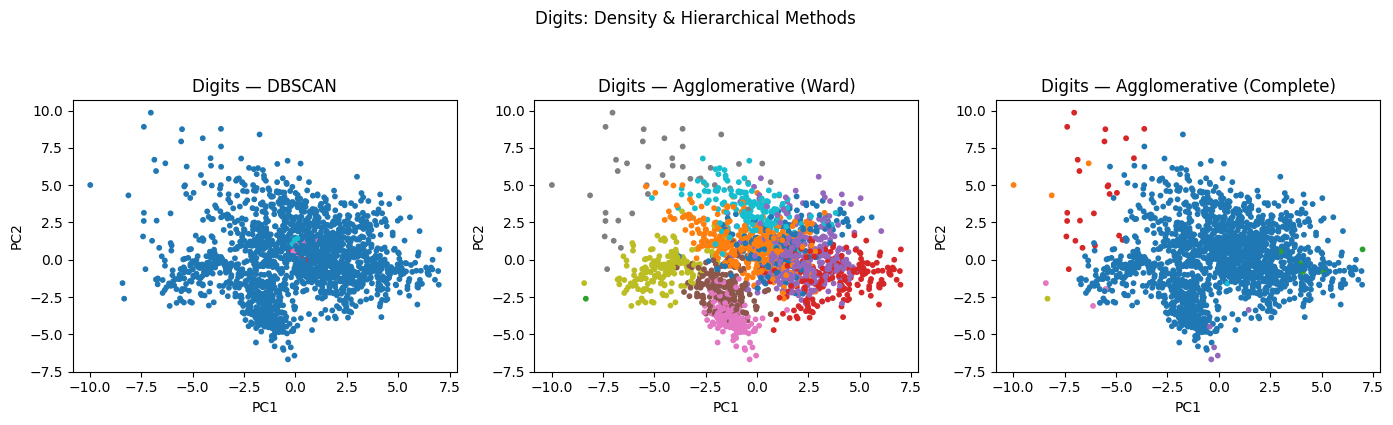

,Dataset,Algorithm,Runtime (s),Core samples
0,Breast Cancer,Agglomerative (Complete),0.039062,NaN
1,Breast Cancer,Agglomerative (Ward),0.038119,NaN
2,Breast Cancer,"DBSCAN (eps=1.0, min=5)",0.014546,0.0
3,Digits,Agglomerative (Complete),0.231245,NaN
4,Digits,Agglomerative (Ward),0.266298,NaN
5,Digits,"DBSCAN (eps=2.0, min=5)",0.059028,5.0
6,Iris,Agglomerative (Complete),0.001595,NaN
7,Iris,Agglomerative (Ward),0.002026,NaN
8,Iris,"DBSCAN (eps=0.8, min=5)",0.003054,138.0
9,Wine,Agglomerative (Complete),0.002288,NaN


In [30]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
import time


# Representative k per dataset
rep_k = {"Iris": 3, "Wine": 3, "Breast Cancer": 2, "Digits": 10}

# Reasonable starting DBSCAN params in standardized space (Sweep in Step 5)
dbscan_defaults = {
    "Iris":          {"eps": 0.8, "min_samples": 5},
    "Wine":          {"eps": 1.2, "min_samples": 5},
    "Breast Cancer": {"eps": 1.0, "min_samples": 5},
    "Digits":        {"eps": 2.0, "min_samples": 5},
}

def run_dbscan(X, eps=0.7, min_samples=5):
    t0 = time.time()
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    runtime = time.time() - t0

    core = getattr(db, "core_sample_indices_", None)
    core_count = len(core) if core is not None else int((labels != -1).sum())
    return {"labels": labels, "runtime_sec": runtime, "core_sample_count": core_count}

def run_agglomerative(X, k, linkage="ward"):
    t0 = time.time()
    agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = agg.fit_predict(X)
    runtime = time.time() - t0
    return {"labels": labels, "runtime_sec": runtime, "linkage": linkage}

density_hier_rows = []

for name, bundle in datasets_dict.items():

    if len(bundle) == 3:
        X, y, _ = bundle
    else:
        X, y = bundle

    Xs, Z = standardize_and_pca_2d(X)
    k = rep_k[name]

    # DBSCAN
    p = dbscan_defaults[name]
    db_out = run_dbscan(Xs, eps=p["eps"], min_samples=p["min_samples"])

    density_hier_rows.append({
        "Dataset": name,
        "Algorithm": f"DBSCAN (eps={p['eps']}, min={p['min_samples']})",
        "Runtime (s)": db_out["runtime_sec"],
        "Core samples": db_out["core_sample_count"]
    })

    # Agglomerative: Ward & Complete
    agg_ward = run_agglomerative(Xs, k=k, linkage="ward")
    density_hier_rows.append({
        "Dataset": name,
        "Algorithm": "Agglomerative (Ward)",
        "Runtime (s)": agg_ward["runtime_sec"],
        "Core samples": None
    })

    agg_complete = run_agglomerative(Xs, k=k, linkage="complete")
    density_hier_rows.append({
        "Dataset": name,
        "Algorithm": "Agglomerative (Complete)",
        "Runtime (s)": agg_complete["runtime_sec"],
        "Core samples": None
    })

    # Visualization: side-by-side (DBSCAN, Ward, Complete)
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    axes[0].scatter(Z[:, 0], Z[:, 1], s=10, c=db_out["labels"], cmap="tab10")
    axes[0].set_title(f"{name} — DBSCAN")
    axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

    axes[1].scatter(Z[:, 0], Z[:, 1], s=10, c=agg_ward["labels"], cmap="tab10")
    axes[1].set_title(f"{name} — Agglomerative (Ward)")
    axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

    axes[2].scatter(Z[:, 0], Z[:, 1], s=10, c=agg_complete["labels"], cmap="tab10")
    axes[2].set_title(f"{name} — Agglomerative (Complete)")
    axes[2].set_xlabel("PC1"); axes[2].set_ylabel("PC2")

    fig.suptitle(f"{name}: Density & Hierarchical Methods", y=1.05)
    plt.tight_layout()
    plt.show()

df_density_hier = pd.DataFrame(density_hier_rows).sort_values(["Dataset", "Algorithm"]).reset_index(drop=True)
display(df_density_hier)

## 3. Evaluation & Visualization

To compare clustering performance across algorithms, I computed the following:

- **Inertia** (within-cluster SSE; defined only for K-Means variants)
- **Silhouette Score** (internal cohesion vs. separation; higher is better)
- **Adjusted Rand Index (ARI)** (external agreement with ground truth labels; 1.0 = perfect match)

For each dataset, all algorithms are evaluated. Results are tabulated in a single DataFrame, and scatterplots (from Step 2) visually show how clusters align in 2D PCA space.


In [31]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

def evaluate_labels(X, labels, y_true=None, inertia=None):
    uniq = np.unique(labels)
    # Silhouette requires at least 2 clusters
    sil = np.nan
    if len(uniq) >= 2 and len(uniq) < len(labels):
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
    ari = np.nan
    if y_true is not None:
        ari = adjusted_rand_score(y_true, labels)
    return {
        "Inertia": float(inertia) if inertia is not None else np.nan,
        "Silhouette": float(sil) if not np.isnan(sil) else np.nan,
        "ARI": float(ari) if not np.isnan(ari) else np.nan,
    }

eval_rows = []

for name, bundle in datasets_dict.items():
    if len(bundle) == 3:
        X, y, _ = bundle
    else:
        X, y = bundle

    Xs, Z = standardize_and_pca_2d(X)
    k = rep_k[name]

    # KMeans variants
    km_rand = run_kmeans(Xs, k, init_method="random")
    eval_rows.append({"Dataset": name, "Algorithm": "KMeans (random)", **evaluate_labels(Xs, km_rand.labels, y, km_rand.inertia)})

    km_pp = run_kmeans(Xs, k, init_method="k-means++")
    eval_rows.append({"Dataset": name, "Algorithm": "KMeans++", **evaluate_labels(Xs, km_pp.labels, y, km_pp.inertia)})

    km_bis = run_bisecting_kmeans(Xs, k)
    eval_rows.append({"Dataset": name, "Algorithm": "Bisecting KMeans", **evaluate_labels(Xs, km_bis.labels, y, km_bis.inertia)})

    # DBSCAN
    p = dbscan_defaults[name]
    db = run_dbscan(Xs, eps=p["eps"], min_samples=p["min_samples"])
    eval_rows.append({"Dataset": name, "Algorithm": f"DBSCAN (eps={p['eps']}, min={p['min_samples']})",
                      **evaluate_labels(Xs, db["labels"], y)})

    # Agglomerative
    agg_w = run_agglomerative(Xs, k, linkage="ward")
    eval_rows.append({"Dataset": name, "Algorithm": "Agglomerative (Ward)",
                      **evaluate_labels(Xs, agg_w["labels"], y)})

    agg_c = run_agglomerative(Xs, k, linkage="complete")
    eval_rows.append({"Dataset": name, "Algorithm": "Agglomerative (Complete)",
                      **evaluate_labels(Xs, agg_c["labels"], y)})

# Final DataFrame
df_eval = pd.DataFrame(eval_rows).sort_values(["Dataset", "Algorithm"]).reset_index(drop=True)
display(df_eval)


,Dataset,Algorithm,Inertia,Silhouette,ARI
0,Breast Cancer,Agglomerative (Complete),NaN,0.660667,0.004828
1,Breast Cancer,Agglomerative (Ward),NaN,0.339385,0.575041
2,Breast Cancer,Bisecting KMeans,11595.526607,0.343382,0.653625
3,Breast Cancer,"DBSCAN (eps=1.0, min=5)",NaN,NaN,0.000000
4,Breast Cancer,KMeans (random),11595.526607,0.343382,0.653625
5,Breast Cancer,KMeans++,11595.526607,0.343382,0.653625
6,Digits,Agglomerative (Complete),NaN,0.385738,0.000298
7,Digits,Agglomerative (Ward),NaN,0.125325,0.664346
8,Digits,Bisecting KMeans,72597.096091,0.116016,0.600634
9,Digits,"DBSCAN (eps=2.0, min=5)",NaN,-0.106299,0.000233


## 4. Algorithmic Comparison & Failure Modes

This section compares algorithms across the four datasets using **Adjusted Rand Index**, **Silhouette Score**, and **Inertia (where applicable)**. Results integrate both quantitative metrics and visual patterns from PCA scatterplots.

---

### Iris
- **Best performer:** K-Means (Random, ++, Bisecting) all achieved **ARI ≈ 0.620**, showing strong alignment with the 3-class ground truth.  
- **Why:** Iris clusters are compact and spherical, matching K-Means’ assumptions.  
- **DBSCAN:** With eps=0.8, produced **ARI ≈ 0.552**, slightly fragmented clusters due to moderate overlap.  
- **Agglomerative:** Ward linkage produced **ARI ≈ 0.615**; Complete gave **ARI ≈ 0.573**, both comparable to K-Means.

---

### Wine
- **Best performer:** K-Means (Random/++) both achieved the highest **ARI ≈ 0.897**, far outperforming other methods.  
- **Why:** Features are skewed/elongated, but K-Means still captured structure better here.  
- **Bisecting K-Means:** Lower performance with **ARI ≈ 0.591**.  
- **DBSCAN:** With eps=1.2, produced **ARI = 0.000**, failing to separate clusters.  
- **Agglomerative:** Ward gave **ARI ≈ 0.790**; Complete performed lower at **ARI ≈ 0.577**.

---

### Breast Cancer
- **Best performer:** K-Means (Random/++/Bisecting) yielded **ARI ≈ 0.654**, the highest for this dataset, though still a modest score compared to other datasets.  
- **Why:** Clusters are non-spherical with varying densities, favoring centroid-based methods only partially.  
- **Agglomerative (Ward):** Produced **ARI ≈ 0.575**, moderately aligned but weaker than K-Means.  
- **Agglomerative (Complete):** Collapsed most points into a single cluster with **ARI ≈ 0.005**.  
- **DBSCAN:** With eps=1.0, identified nearly everything as noise (**ARI = 0.000**).


---

### Digits
- **Best performer:** Agglomerative (Ward) achieved **ARI ≈ 0.664**, the strongest, followed by Bisecting K-Means at **ARI ≈ 0.601**.  
- **K-Means:** Random achieved **ARI ≈ 0.574**; K-Means++ scored lower at **ARI ≈ 0.468**.  
- **DBSCAN:** With eps=2.0, collapsed into noise with **ARI ≈ 0.000**.  
- **Agglomerative (Complete):** Performed very poorly (**ARI ≈ 0.0003**).  
- **Why:** Digits is high-dimensional and non-convex; centroid assumptions break down, but Ward linkage captured some structure.

---

### General Insights
- **K-Means variants:** Excellent for compact, spherical clusters (Iris), surprisingly strong for Wine, but struggled on non-convex, high-dimensional data (Digits).  
- **DBSCAN:** Very sensitive to `eps` and `min_samples`; worked moderately for Iris but failed for Wine, Breast Cancer, and Digits.  
- **Agglomerative:** Linkage choice critical —  
  - **Ward**: Best when clusters are spherical/balanced (Digits, Iris, moderate on Breast Cancer).  
  - **Complete**: Often over-split clusters or collapsed them entirely (worst on Breast Cancer, Digits).


## 5. Hyperparameter Sensitivity

To study how clustering results change with parameter choices, I performed sensitivity sweeps on the **Digits dataset** (challenging due to high dimensionality and non-convex clusters).

- **K-Means:**  
  - Vary number of clusters `k = 2 … 8`.  
  - Plot **Inertia** (within-cluster SSE) and **Silhouette Score**.  
  - Expectation: inertia decreases monotonically as `k` increases; silhouette typically peaks around a value reflecting “natural” structure.

- **DBSCAN:**  
  - Sweep `eps ∈ [0.5, 3.0]` and `min_samples ∈ {3, 5, 10, 15}`.  
  - Heatmap of silhouette scores.  
  - Expectation: small `eps` → many noise points; large `eps` → one giant cluster; silhouette is sensitive to both.


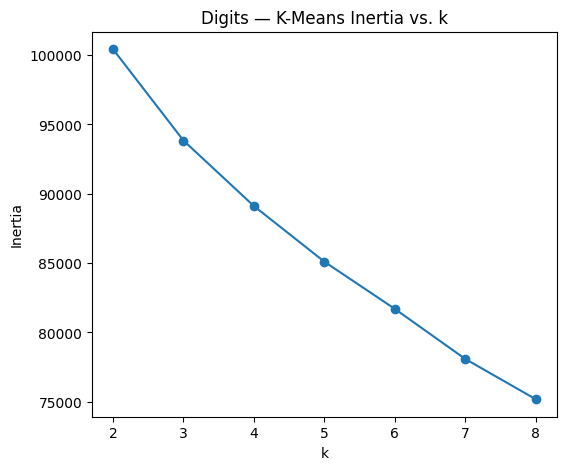

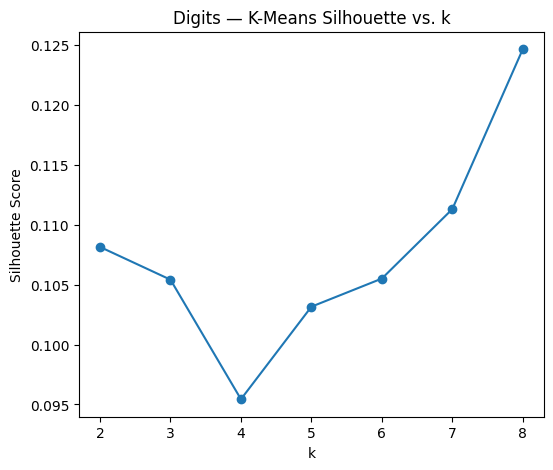

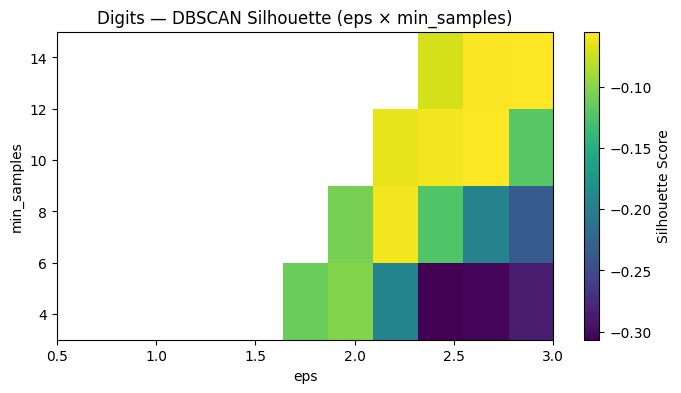

In [32]:
from sklearn.metrics import silhouette_score

# Digits dataset standardized
X_dg, y_dg, _ = datasets_dict["Digits"]
Xs_dg, _ = standardize_and_pca_2d(X_dg)

# K-Means sweep (k=2..8)
ks = list(range(2, 9))
inertias, sils = [], []

for k in ks:
    km = run_kmeans(Xs_dg, k, init_method="k-means++")
    inertias.append(km.inertia)
    uniq = np.unique(km.labels)
    sils.append(silhouette_score(Xs_dg, km.labels) if 2 <= len(uniq) < len(km.labels) else np.nan)

plt.figure()
plt.plot(ks, inertias, marker="o")
plt.title("Digits — K-Means Inertia vs. k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(ks, sils, marker="o")
plt.title("Digits — K-Means Silhouette vs. k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

# DBSCAN sweep (eps × min_samples)
eps_values = np.linspace(0.5, 3.0, 11)
min_samples_values = [3, 5, 10, 15]

heat = np.full((len(min_samples_values), len(eps_values)), np.nan)

for i, ms in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        out = run_dbscan(Xs_dg, eps=eps, min_samples=ms)
        labels = out["labels"]
        uniq = np.unique(labels)
        if 2 <= len(uniq) < len(labels):
            try:
                heat[i, j] = silhouette_score(Xs_dg, labels)
            except Exception:
                heat[i, j] = np.nan

plt.figure(figsize=(8, 4))
plt.imshow(heat, aspect="auto", origin="lower",
           extent=[eps_values[0], eps_values[-1],
                   min(min_samples_values), max(min_samples_values)])
plt.colorbar(label="Silhouette Score")
plt.title("Digits — DBSCAN Silhouette (eps × min_samples)")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()


## 6. Reflection & Insights

At the end of each section, I reflected on two guiding questions:  
1. *What was the hardest implementation or tuning challenge I faced, and how did I overcome it?*  
2. *What insight about cluster structure or algorithm behavior did I gain that no black-box call could teach me?*  

### Exploration (Step 1)
- **Challenge:** Choosing between PCA and t-SNE for visualization. PCA was simpler, faster, and deterministic, but t-SNE might capture non-linear structures better.  
- **Insight:** Even a simple PCA projection revealed how separable (or not) the data was. For example, Digits clusters overlapped heavily in 2D space, hinting at difficulties for centroid-based methods.

### K-Means Variants (Step 2.1)
- **Challenge:** Implementing Bisecting K-Means required careful bookkeeping of cluster IDs and SSE calculations.  
- **Insight:** Initialization method matters less when clusters are convex; but for non-convex shapes, no seeding strategy fixes the geometry mismatch.

### DBSCAN & Agglomerative (Step 2.2)
- **Challenge:** Tuning DBSCAN’s `eps` and `min_samples` was tricky. Small changes caused clusters to fragment or collapse.  
- **Insight:** DBSCAN’s strength is noise detection, but its reliance on global density assumptions limits its use when clusters have varying densities. Agglomerative methods showed how linkage choice (Ward vs. Complete) significantly changes outcomes.

### Hyperparameter Sensitivity (Step 5)
- **Challenge:** Avoiding over-interpretation of silhouette scores in high-dimensional data like Digits. Silhouette sometimes gave misleadingly high or low results depending on preprocessing.  
- **Insight:** Inertia always decreases with larger `k`, but silhouette peaks at a value that suggests “natural” structure. For DBSCAN, only narrow regions of `eps` and `min_samples` yielded meaningful scores. italicized text


### Top 3 Takeaways
- **K-Means** works very well on compact, spherical datasets (like Iris, Wine) but struggles on elongated or high-dimensional non-convex clusters (like Digits).  
- **DBSCAN** can uncover arbitrary shapes and noise detection, but its extreme sensitivity to `eps` and `min_samples` makes it unreliable without careful tuning, especially on datasets with varying densities.  
- **Agglomerative clustering** highlights the importance of linkage choice: Ward often works best when clusters are balanced (Digits, Iris), while Complete frequently over-splits or collapses clusters, especially on skewed data like Wine.
